# Imports

In [1]:
import sys
import numpy as np
import torch
from tqdm.notebook import tqdm


from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import Voronoi, Delaunay

sys.path.append('../')

from models.models import *
from src.mesh_util import *
from src.data_util import *

In [2]:
# load data

filenames = {'baseline_64': 'kolmogorov_re_1000/eval_2048x2048_64x64.nc'}

data = load_dataset(filenames,path='../data/')
data = data['baseline_64']

x_range = (data.x.min().item(),data.x.max().item())
y_range = (data.y.min().item(),data.y.max().item())

print(x_range,y_range)


(0.04908738657832146, 6.234097957611084) (0.04908738657832146, 6.234097957611084)


# Mesh Setup
## Setup a staggered grid with delaunay triangles to connect adjacent points

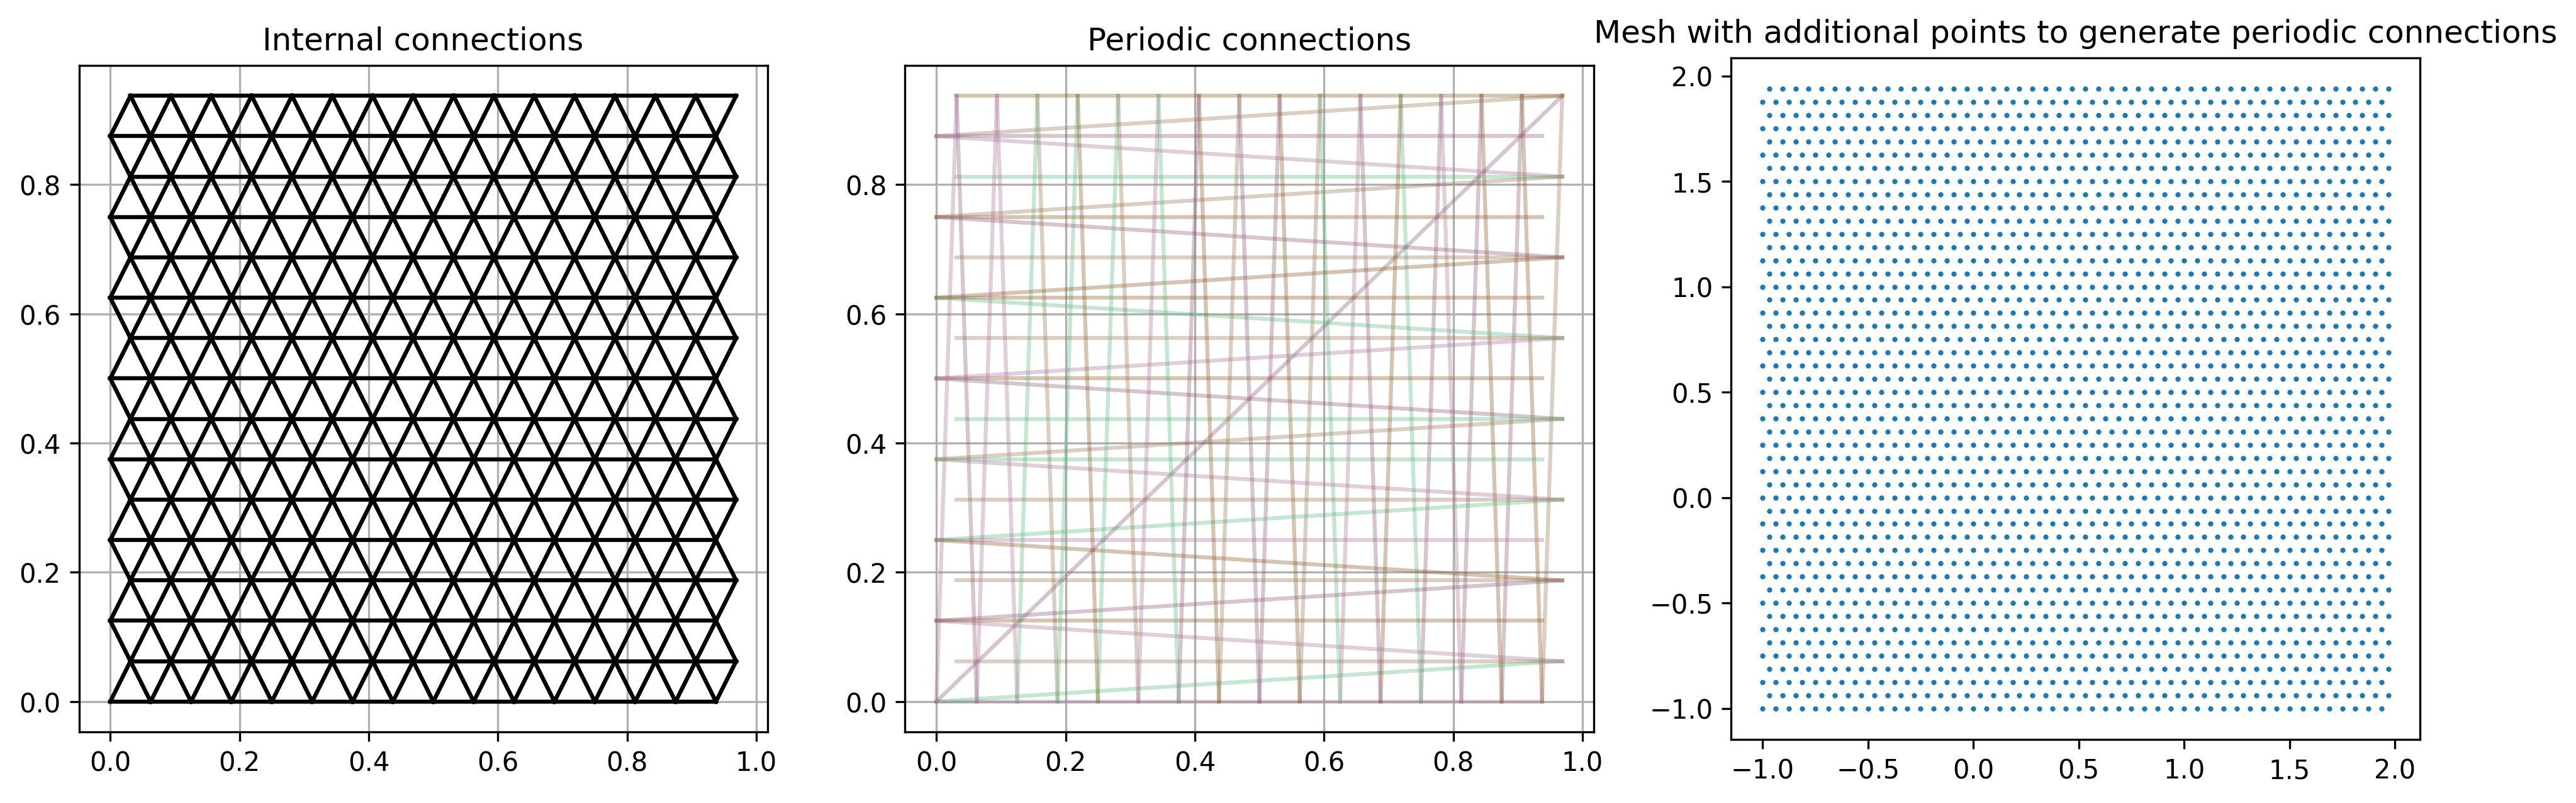

[88 89 89 ... 43 43 26]


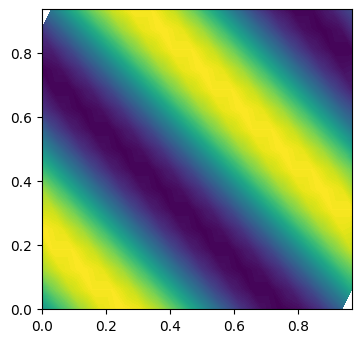

In [3]:
# setup mesh

rows = 64
cols = 64

rows = 16
cols = 16

# rows = 4
# cols = 4

x_range = (0,1)
y_range = (0,1)

# print(data.x.min().values)
staggered_points = np.empty((rows,cols,2))
# staggered_points[:,:,1] = np.linspace(data.x.min().values,data.x.max().values - (y_range[1]-y_range[0])/(rows-1)/2,rows)[:,np.newaxis]
staggered_points[:,:,1] = np.linspace(data.x.min().values,data.x.max().values,rows)[:,np.newaxis]
for i in range(rows):
    point_row = np.linspace(data.y.min().values,data.y.max().values,cols)
    staggered_points[i,:,0] = point_row + i%2*((data.y.max().values-data.y.min().values)/(cols-1)/2) # stagger 
    # points[i,:,0] = point_row 

# consistent spacing
dx = (x_range[1]-x_range[0])/(rows)
dy = (y_range[1]-y_range[0])/(cols)
staggered_points[:,:,1] = np.arange(y_range[0],y_range[1]-dy/10,dy)[:,np.newaxis]
for i in range(rows):
    point_row = np.arange(x_range[0],x_range[1]-6*dx/10,dx)
    staggered_points[i,:,0] = point_row + i%2*(dx/2) # stagger

staggered_points = staggered_points.reshape(-1,2)

mesh_nonperiodic = Delaunay(staggered_points)

connectivity_nonperiodic = delanay_simplex_to_connectivity_array(mesh_nonperiodic,True)

spacing = (x_range[1]-x_range[0])/(rows-1)
original_spacing = (data.x.max().values - data.x.min().values)/64
# mesh, connectivity, connectivity_periodic, edge_attr = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]+dx/2],[y_range[0],y_range[1]+dy]]))
mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))
# mesh, connectivity, connectivity_periodic, dx = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[0,2*np.pi],[0,2*np.pi]]))

fig = plt.figure(figsize=(16,6),dpi=300)
ax = fig.add_subplot(131)
ax.plot(staggered_points[connectivity,0],staggered_points[connectivity,1],c='k')
ax.set_aspect('equal')
ax.set_title('Internal connections')
ax.grid(True)
ax = fig.add_subplot(132)
ax.plot(staggered_points[connectivity_periodic,0],staggered_points[connectivity_periodic,1],alpha=0.2)
ax.set_title('Periodic connections')
ax.set_aspect('equal')
ax.grid(True)

# fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.add_subplot(133)
ax.scatter(mesh.points[:,0],mesh.points[:,1],s=1)
ax.set_title('Mesh with additional points to generate periodic connections')
ax.set_aspect('equal')
plt.show()

print(connectivity[0])

# setup values
vals = staggered_points.sum(1)%1
vals = np.sin((staggered_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi)
# print(vals)

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax.tricontourf(staggered_points[:,0],staggered_points[:,1],vals,levels=100)
ax.set_aspect('equal')
plt.show()

# combine connectivities
connectivity_combined = np.concatenate([connectivity,connectivity_periodic],axis=1)

# combine relative position
edge_attr_combined = np.concat([edge_attr,edge_attr_periodic],axis=0)
# print(edge_attr_combined.shape)


# Model Setup
## Create a sample mesh graph net to test model implementation

tensor(False, device='mps:0')
tensor(False, device='mps:0')
torch.Size([1536, 2]) torch.Size([256, 1]) torch.Size([2, 1536])


  0%|          | 0/10000 [00:00<?, ?it/s]

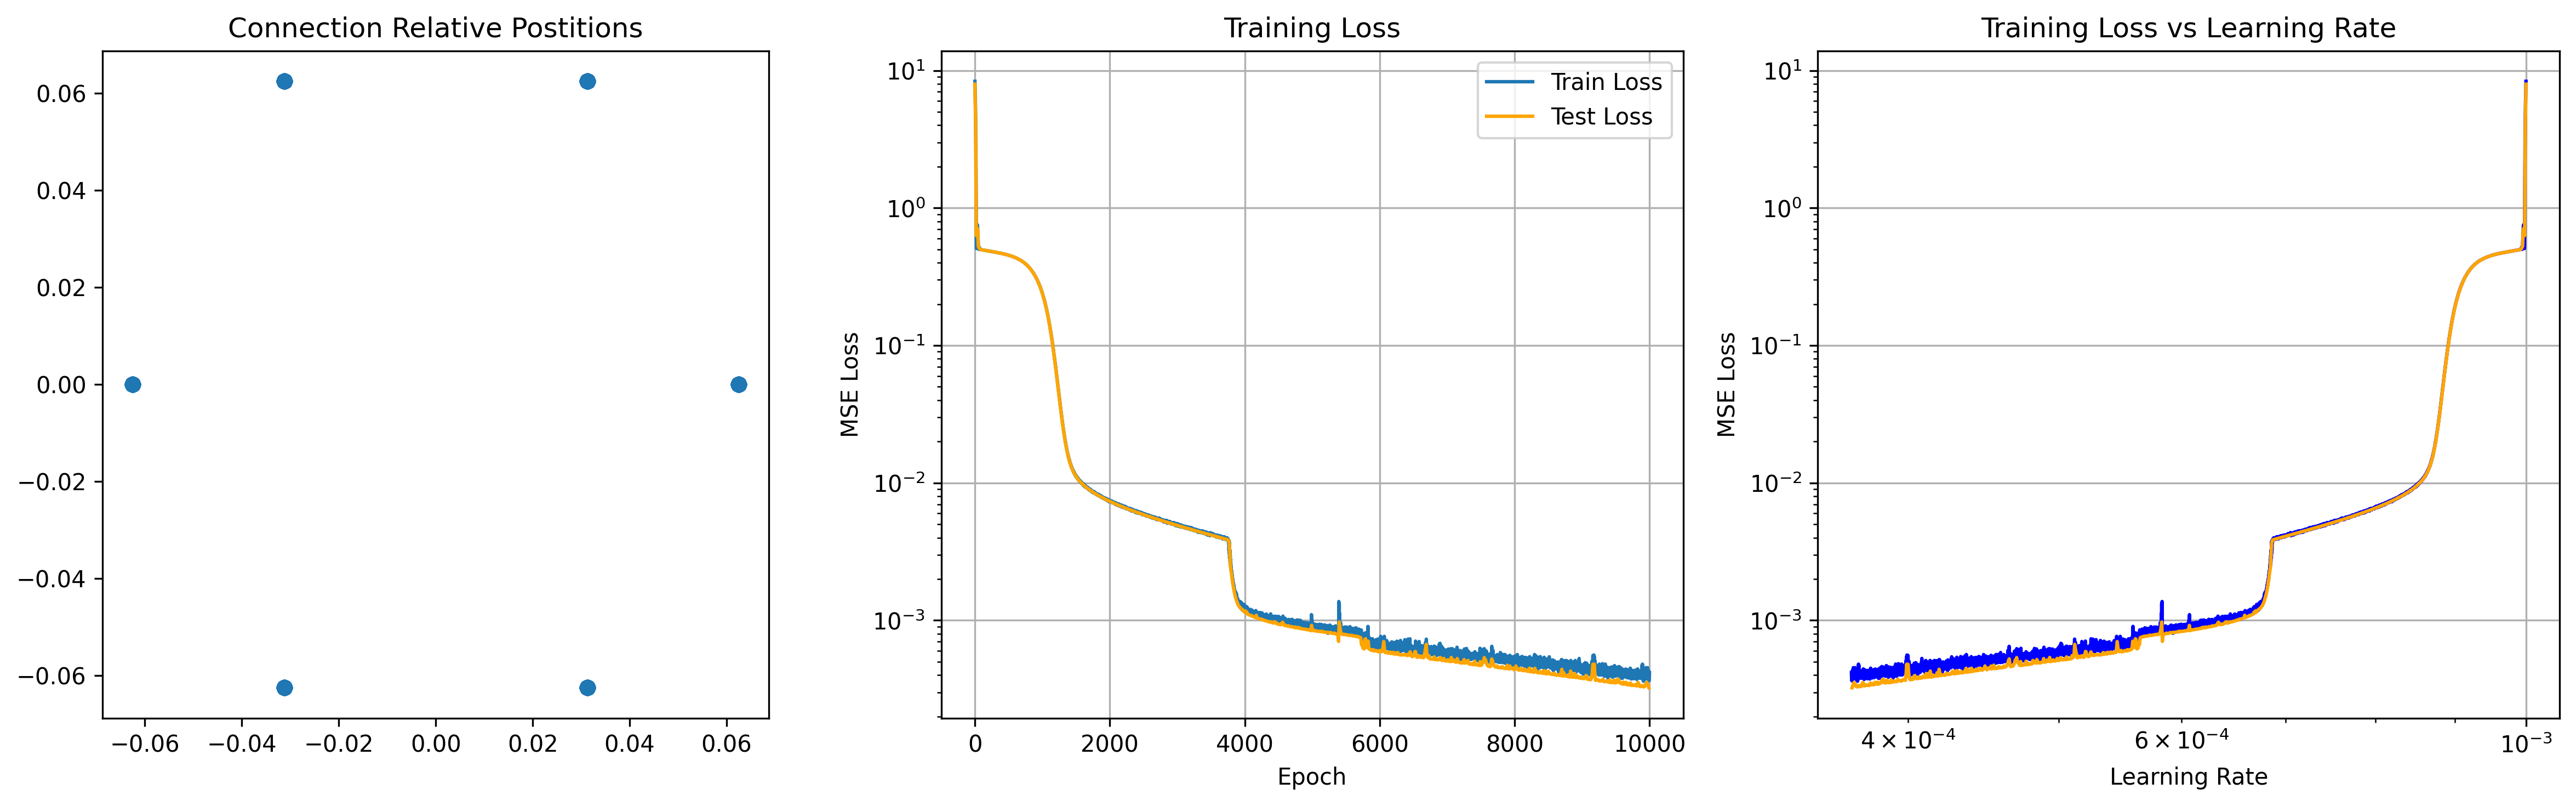

In [4]:
# construct model
model = MeshGraphNet(npasses=1,
                     ndim=2,
                     node_fc_depth=2,
                     edge_fc_depth=2,
                     node_input_dim=1,
                     edge_input_dim=2,
                     activation=nn.SiLU(),
                     dropout_rate=0.00).to('mps')

# e = edge_attr


# set device
e = torch.tensor(edge_attr_combined,dtype=torch.float32).to('mps')
# v0 = torch.tensor(np.sin((staggered_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi),dtype=torch.float32).to('mps').unsqueeze(-1)
v0 = torch.tensor(vals,dtype=torch.float32).to('mps').unsqueeze(-1)
v1 = (v0+0.2)%1
v1 = torch.tensor(np.sin((staggered_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi+1.5),dtype=torch.float32).to('mps').unsqueeze(-1)
ij = torch.tensor(connectivity_combined,dtype=torch.long).to('mps')

shift_x = 1
shift_y = 0
shifted_points = staggered_points + np.array([dx*shift_x,dy*shift_y])

# test values
v_test = torch.tensor(np.sin((shifted_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi),dtype=torch.float32).to('mps').unsqueeze(-1)
v_target = torch.tensor(np.sin((shifted_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi+1.5),dtype=torch.float32).to('mps').unsqueeze(-1)

print(torch.all(v_test == v0))
print(torch.all(v_target == v1))

print(e.shape,v0.shape,ij.shape)

# train model

opt = torch.optim.Adam(model.parameters(),lr=1e-3)
decay = torch.optim.lr_scheduler.ExponentialLR(opt,0.9999)
# decay = torch.optim.lr_scheduler.ExponentialLR(opt,1.0)
loss_fn = torch.nn.MSELoss()
model.train()

loss_hist = []
test_loss_hist = []
lr_hist = []

epochs = 10000
test_interval = 10
pbar = tqdm(range(epochs))
for i in pbar:

    model.zero_grad()
    pred = model(v0+torch.randn_like(v0)*0.001,ij,e)
    loss = loss_fn(pred,v1)
    
    loss.backward()
    opt.step()
    decay.step()

    # tqdm.write(f"Step {i}: Loss {loss.item()}")
    loss_hist.append(loss.item())
    lr_hist.append(opt.param_groups[0]['lr'])

    if i%test_interval == 0:
        model.eval()
        pred_test = model(v_test,ij,e)
        test_loss = loss_fn(pred_test,v_target)
        test_loss_hist.append(test_loss.item())
        model.train()
    pbar.set_postfix({'Step': i, 'Train Loss': loss.item(), 'Test Loss': test_loss.item(),'LR': opt.param_groups[0]['lr']})

# # plot loss
# plt.figure()
# plt.semilogy(loss)
# plt.xlabel('Training Step')
# plt.ylabel('MSE Loss')
# plt.title('Training Loss Curve')
# plt.grid()

fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(131)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')

# fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(132)
ax.plot(loss_hist,label='Train Loss')
ax.plot(range(0,epochs,test_interval),test_loss_hist,label='Test Loss',c='orange')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(lr_hist,loss_hist, label='Train Loss', c='blue')
ax.plot(lr_hist[::test_interval],test_loss_hist,label='Test Loss', c='orange')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss vs Learning Rate')
ax.grid(True)

fig.tight_layout()
plt.show()
# plt.show()


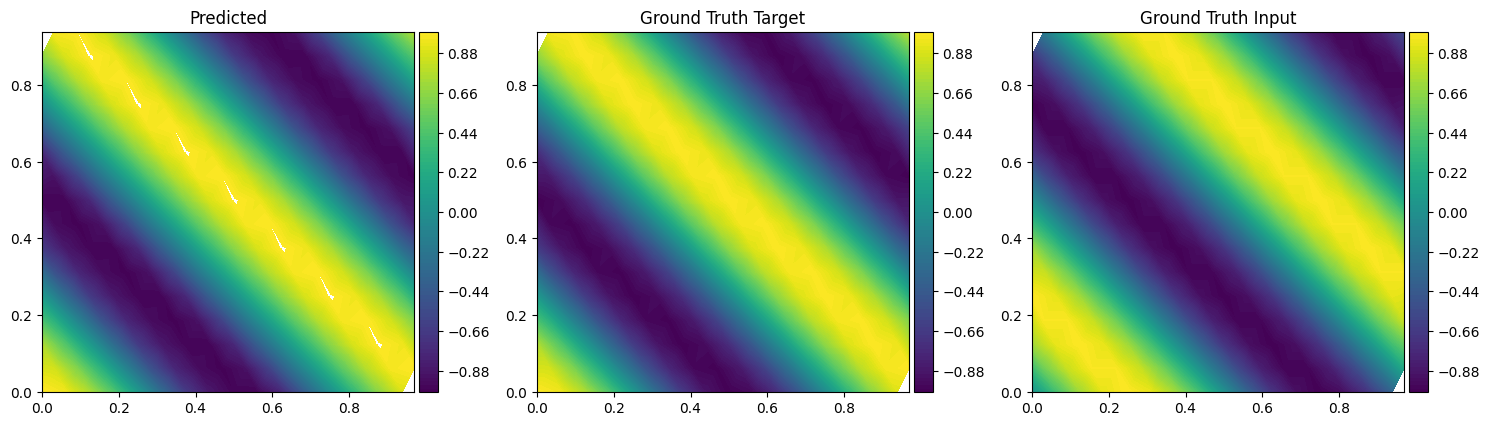

In [5]:
# visualize last predictions

model.eval()
pred = model(v0,ij,e)


levels = np.linspace(-1,1,101)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],pred.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Predicted')
plt.colorbar(cbar,cax=cax)

ax = fig.add_subplot(132)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v1.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Ground Truth Target')
plt.colorbar(cbar,cax=cax)

ax = fig.add_subplot(133)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v0.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Ground Truth Input')
plt.colorbar(cbar,cax=cax)

fig.tight_layout()

plt.show()

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

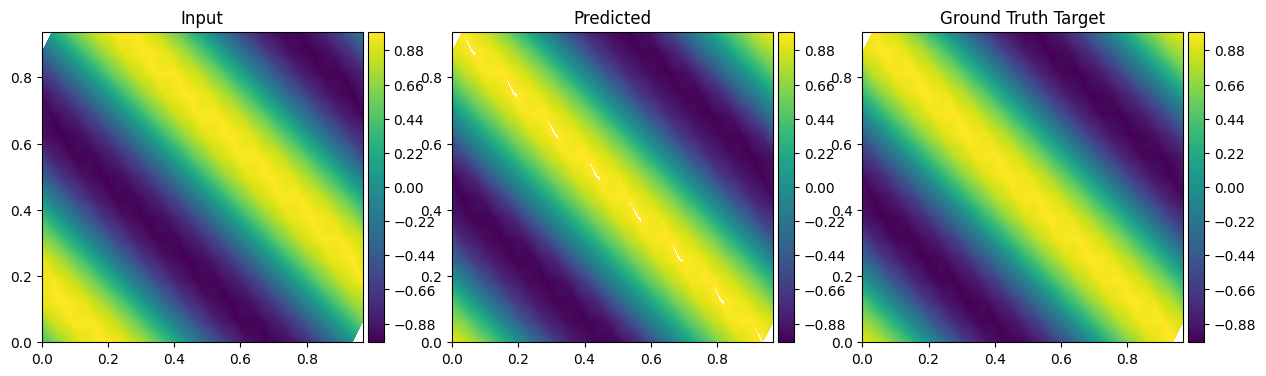

In [6]:
model.eval()
shift_x = 1
shift_y = 0
shifted_points = staggered_points + np.array([dx*shift_x,dy*shift_y])

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(staggered_points[:,0],staggered_points[:,1],s=5,c='blue',alpha=0.5)
# ax.scatter(shifted_points[:,0],shifted_points[:,1],s=5,c='red',alpha=0.5)

# test values
v_test = torch.tensor(np.sin((shifted_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi),dtype=torch.float32).to('mps').unsqueeze(-1)
v_target = torch.tensor(np.sin((shifted_points.sum(1))/(x_range[1]-x_range[0])*2*np.pi+1.5),dtype=torch.float32).to('mps').unsqueeze(-1)
check_bool = [ele in v0 for ele in v_test]
print(check_bool)
check_diff = [torch.abs(v0-ele).min().item() for ele in v_test]
print(check_diff)

pred_test = model(v_test,ij,e)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v_test.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Input')
plt.colorbar(cbar,cax=cax)


ax = fig.add_subplot(132)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],pred_test.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Predicted')
plt.colorbar(cbar,cax=cax)

ax = fig.add_subplot(133)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v_target.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Ground Truth Target')
plt.colorbar(cbar,cax=cax)

plt.show()

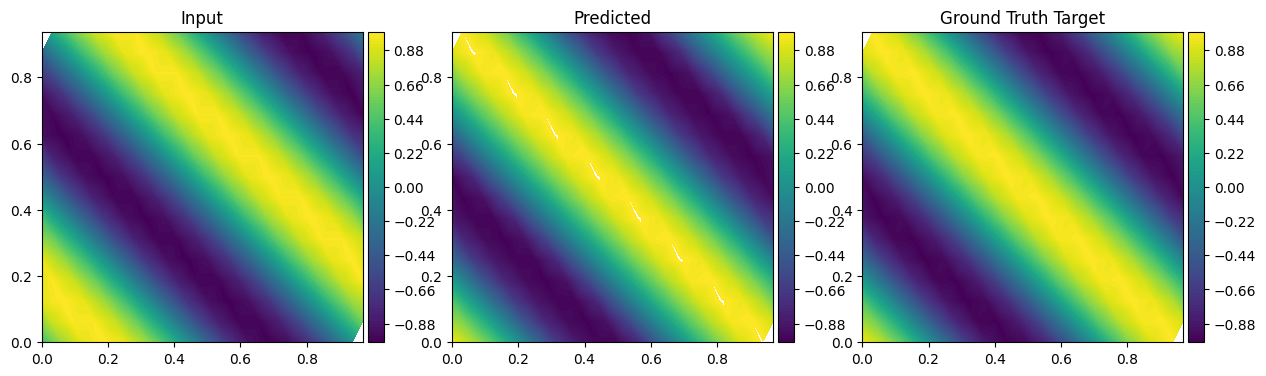

In [7]:
v_test = v0.detach().clone().reshape(rows,cols)
v_test = torch.roll(v_test,shifts=-1,dims=1)
v_target = v1.detach().clone().reshape(rows,cols)
v_target = torch.roll(v_target,shifts=-1,dims=1)

v_test = v_test.reshape(-1,1)
v_target = v_target.reshape(-1,1)

pred_test = model(v_test,ij,e)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v_test.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Input')
plt.colorbar(cbar,cax=cax)


ax = fig.add_subplot(132)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],pred_test.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Predicted')
plt.colorbar(cbar,cax=cax)

ax = fig.add_subplot(133)
cbar = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],v_target.detach().cpu().squeeze().numpy(),levels=levels,vmin=-1,vmax=1)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title('Ground Truth Target')
plt.colorbar(cbar,cax=cax)

plt.show()

tensor([[  3,   3,   3,   3,   3,   3],
        [  2,  18,  19,   4, 242, 243]], device='mps:0')
tensor([[-0.0625,  0.0000],
        [-0.0312,  0.0625],
        [ 0.0312,  0.0625],
        [ 0.0625,  0.0000],
        [-0.0312, -0.0625],
        [ 0.0312, -0.0625]], device='mps:0')
tensor([0., 0.], device='mps:0')


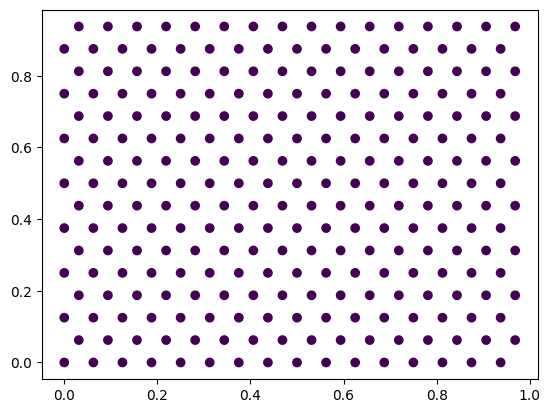

In [8]:
# print(staggered_points)
# print(mesh.points)
# print(np.all(staggered_points == mesh.points))

# print(e)
# print(e.min(),e.max())
# print(e.sum(0))

# print(staggered_points - np.roll(staggered_points,shift=1,axis=0))
# print(dx)
# print(staggered_points)

mask = ij[0] == 3
print(ij[:,mask])
print(e[mask,:])
print(e[mask,:].sum(0))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(staggered_points[:,0],staggered_points[:,1],c=np.array(check_diff))

